# One-dim experiments

In [1]:
import sys
sys.path.append("/home/lauro/code/msc-thesis/svgd")

import jax.numpy as np
from jax import grad, jit, vmap, random, lax, jacfwd
from jax import lax
from jax.ops import index_update, index
import matplotlib.pyplot as plt
import numpy as onp

import utils
import metrics
import stein

import time
import plot
from svgd import SVGD

rkey = random.PRNGKey(0)

/home/lauro/.virtualenvs/msc-thesis/lib/python3.6/site-packages/jax/lib/xla_bridge.py:123: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
# dist = metrics.GaussianMixture([-3, 3], [1, 1], [1/3, 2/3])
dist = metrics.Gaussian(0, 6)

n = 100
d = dist.d

n_steps = 200
svgd = SVGD(dist, n_steps, particle_shape=(n, d), adagrad=False, snapshot_iter=[0, 5, 10, 30, 50, 100, 200])

In [57]:
h = 1000
lr = 1
svgd_stepsize = 1
bandwidth = np.log(h)
print(bandwidth)

6.9077554


In [58]:
rkey = random.split(rkey)[0]

### train

In [59]:
st = time.time()
x, log = svgd.train(rkey, bandwidth, lr, svgd_stepsize, n_steps)
x.block_until_ready()
end = time.time()
print(f"took {end - st} seconds")
print(log["desc"]["bandwidth"][-4:][:, 0])
learned_h = log["desc"]["bandwidth"][-1]
if learned_h == 0:
    learned_h = log["last_bandwidth"]

100%|██████████| 200/200 [00:03<00:00, 65.76it/s]


took 3.089573860168457 seconds
[880.4866  879.9199  879.3541  878.78864]


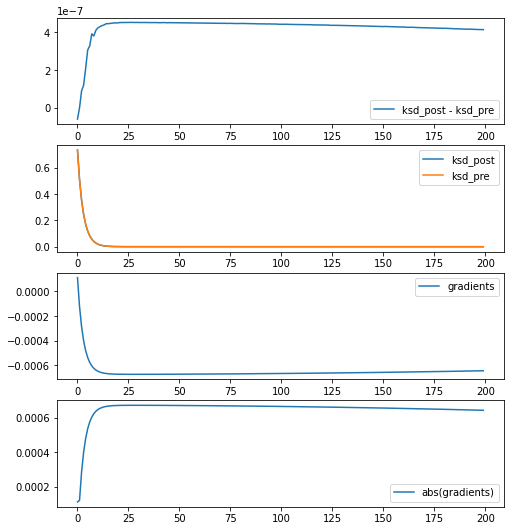

In [60]:
fig, axs = plt.subplots(4,1, figsize=[8, 9])
names = ["ksd_post", "ksd_pre"]
ax = axs[0]
ax.plot(log[names[0]] - log[names[1]], label="ksd_post - ksd_pre")
ax.set_yscale("linear")
ax.legend()

ax = axs[1]
for key in names:
    lines = ax.plot(log[key], label=key)
    ax.set_yscale("linear")
    ax.legend()
    
ax = axs[2]
grads = np.array(log["ksd_gradients"])
plot_grads = (grads, np.abs(grads))
for ax, gradient, label in zip(axs[2:4], plot_grads, ("gradients", "abs(gradients)")):
    ax.plot(gradient, label=label)
    ax.legend()

In [61]:
# plot.svgd_log(log, full=True)

In [62]:
st = time.time()
x0 = svgd.initialize(rkey)
xs, logs = svgd.svgd(x0, svgd_stepsize, bandwidth, n_steps)
end = time.time()
print(f"took {end - st} seconds")

took 0.0012581348419189453 seconds


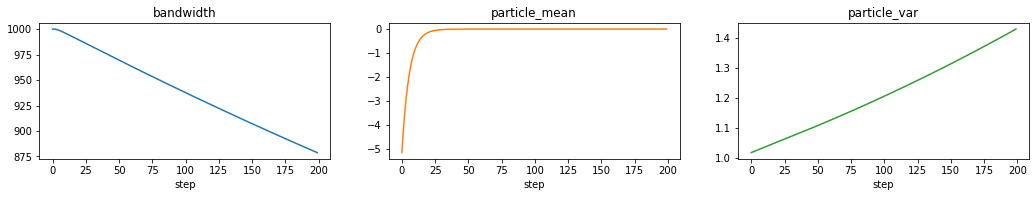

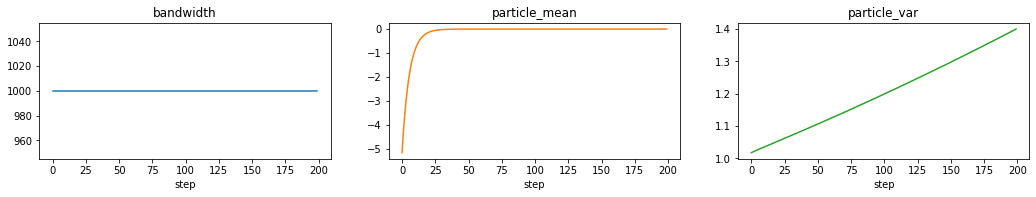

In [63]:
plot.svgd_log(log)#, full=True)
plot.svgd_log(logs)#, full=True)

# Histograms

In [64]:
learned_bandwidth = np.log(learned_h)
x0 = svgd.initialize(rkey)
xsl, logsl = svgd.svgd(x0, svgd_stepsize, learned_bandwidth, n_steps)
end = time.time()
print(f"took {end - st} seconds")

took 0.7362117767333984 seconds


In [65]:
s = dist.sample(shape=(n,1))

## Plot

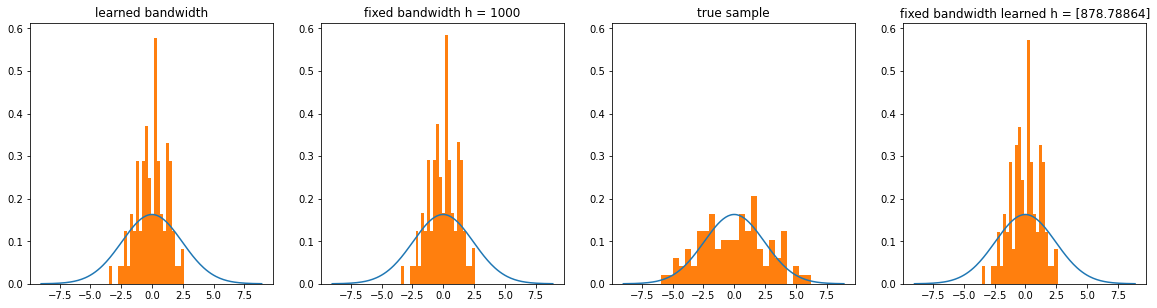

In [66]:
grid = np.arange(-9, 9, 0.1)

fig, axs = plt.subplots(1, 4, figsize = [20, 4.8])
for ax, out, title in zip(axs, (x, xs, s, xsl), ("learned bandwidth", f"fixed bandwidth h = {h}", "true sample", f"fixed bandwidth learned h = {learned_h}")):
    _ = ax.plot(grid, vmap(dist.pdf)(grid))
    _ = ax.hist(out[:, 0], density=True, bins=25)
    _ = ax.set_title(title)

_ = plot.equalize_axes(axs)

# 1d scatterplot

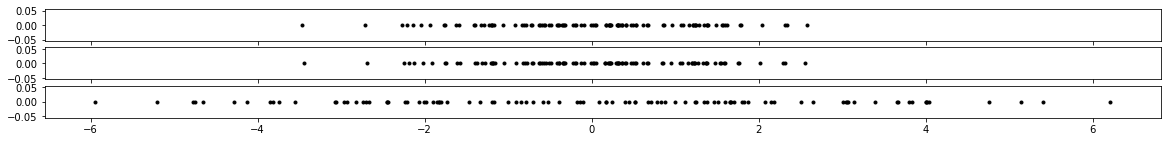

In [67]:
figs, axs = plt.subplots(3, figsize=[20, 2])
# figs.tight_layout = True

titles = ["Learned", "Fixed", "True random"]
samples = [x[:, 0], xs[:, 0], s]
mins = []
maxs = []

for ax, t, sam in zip(axs, titles, samples):
    ax.plot(sam, np.zeros(n), "k.")
#     ax.set_title(t)
    lims = ax.get_xlim()
    mins.append(lims[0])
    maxs.append(lims[1])

lims = [min(mins), max(maxs)]
for ax in axs:
    ax.set_xlim(lims)

# Snapshot of loss landscape
For a given sample taken at step $L$ of the above SVGD + kernel learning process, compute a range of KSD values over a grid of kernel bandwidths.

In [68]:
def sweep(x, hgrid, logp):
    """compute KSD(q, p) using kernel bandwidths in hgrid. Here, q is the empirical dist of x."""
    out =  [stein.ksd_squared(x, logp, np.log(h)) for h in hgrid]
    return np.array(out)

In [69]:
snapshots = log["particle_snapshots"]
h_snapshots = log["bandwidth_snapshots"]
nr_snapshots = len(snapshots)

gridlim = []
gridlim.append(min(-5, *onp.log10(h_snapshots)))
gridlim.append(max(3, *onp.log10(h_snapshots)))
hgrid = np.logspace(*gridlim, num=100)
sweep_results = [sweep(snapshot, hgrid, dist.logpdf) for snapshot in snapshots]

/home/lauro/.virtualenvs/msc-thesis/lib/python3.6/site-packages/jax/lax/lax.py:5104: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/home/lauro/.virtualenvs/msc-thesis/lib/python3.6/site-packages/jax/lax/lax.py:5104: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


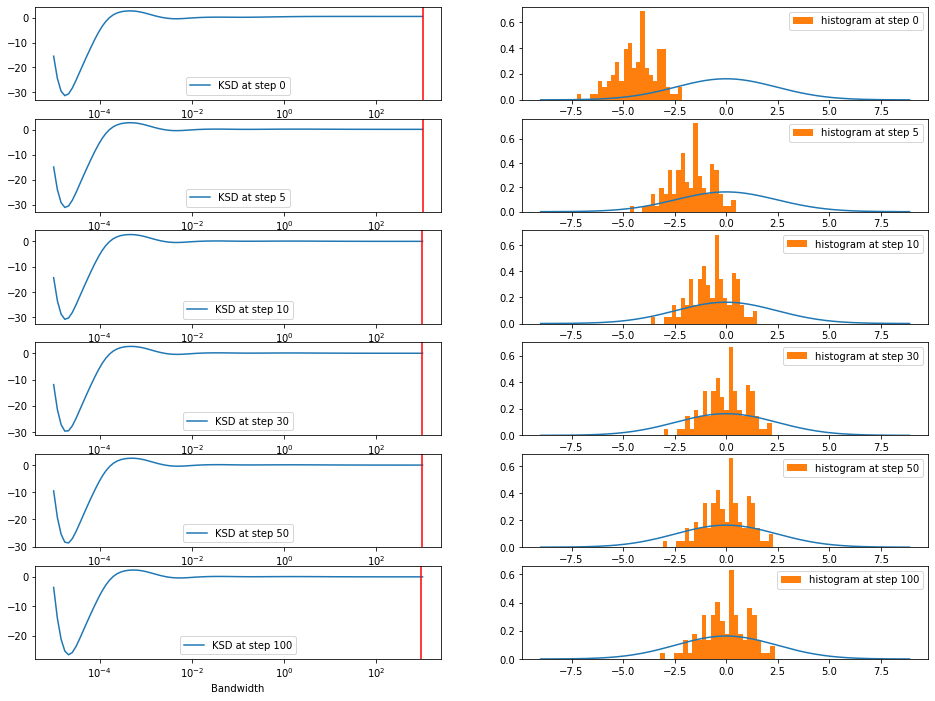

In [70]:
fig, axs = plt.subplots(nr_snapshots, 2, figsize=[16,2*nr_snapshots])
for ax, sweep_res, step, bandwidth in zip(axs[:, 0], sweep_results, svgd.snapshot_iter, h_snapshots):
    ax.plot(hgrid, sweep_res, label=f"KSD at step {step}")
    ax.axvline(x=bandwidth, color="r")
    ax.set_xscale("log")
    ax.legend()
    ax.set_xlabel("Bandwidth")
    # ax.set_yscale("log")
    
grid = np.arange(-9, 9, 0.1)
# fig, axs = plt.subplots(nr_snapshots, 1, figsize=[8,3*nr_snapshots])
for ax, particles, step in zip(axs[:, 1], log["particle_snapshots"], svgd.snapshot_iter):
    _ = ax.plot(grid, vmap(dist.pdf)(grid))
    _ = ax.hist(particles[:, 0], density=True, label=f"histogram at step {step}", bins=25)
    ax.legend()
    # ax.set_yscale("log")